# Analyzing the Shopify Global Catalogue Dataset

Below are all the dependencies we need.

In [9]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import pprint
from mlperf_inference_multimodal_vl2l.task import ShopifyGlobalCatalogue
from openai import OpenAI
import numpy as np

Load the dataset from HuggingFace.

In [ ]:
dataset = load_dataset(
    "Shopify/the-catalogue-public-beta",
    revision="main",
    split="train+test",
    token="...",
)
print(dataset)

Dataset({
    features: ['product_title', 'product_description', 'product_image', 'potential_product_categories', 'ground_truth_brand', 'ground_truth_is_secondhand', 'ground_truth_category'],
    num_rows: 48289
})


Display a sample from the dataset:

An example product at the index 12345:
product_title: Cerulean Solitude Wallpaper with Cosmic Drift
product_description: Share this with your best friend. Send this to your love and swap a matching set. What if the tide carried memories instead of foam? The full resolution of this artwork/wallpaper is 5642 × 11285, with a file size of 13.82 MB MB. Image in App code: qh2777 1:2 Applicable to mobile phones. This product only contains one wallpaper, other wallpapers in the multi-device effect preview need to be purchased separately. Download Information The download link will be on the “Thank You” page once payment is completed. Most wallpaper themes can be instantly downloaded once payment is processed. Few wallpaper backgrounds will generally be processed and sent within 48 hours to your email inbox as our team must confirm that patterns, quality, and links are in proper working order before shipping.
product_image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x1067 at 0x78

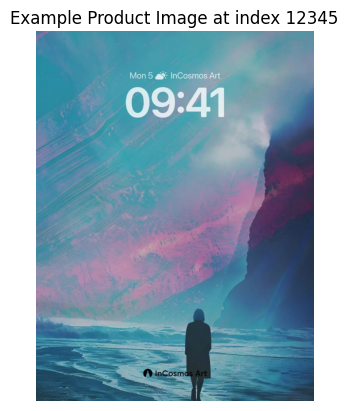

In [28]:
sample_index = 12345
print(f"An example product at the index {sample_index}:")
for key, value in dataset[sample_index].items():
    print(f"==========\n{key}: {value}")
    if isinstance(value, list):
        print(f"{len(value)=}")
plt.imshow(dataset[sample_index]["product_image"])
plt.axis('off')
plt.title(f"Example Product Image at index {sample_index}")
plt.show()

Most samples have 8 or 9 potential product categories:

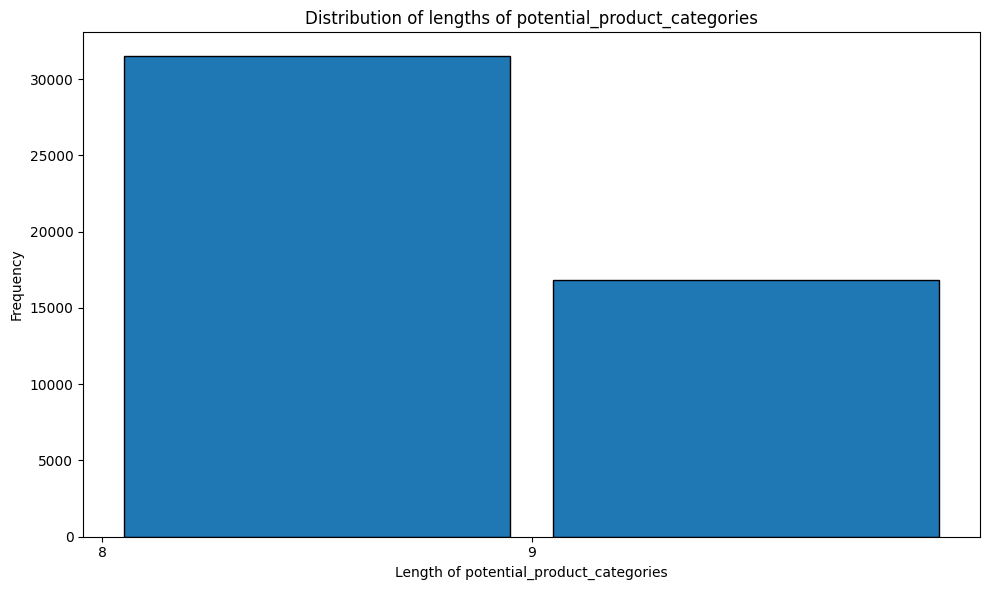

In [12]:
# Plot histogram of the length of potential_product_categories in the split split
def plot_len_potential_product_categories(dataset):
    lengths = [len(product.get("potential_product_categories", [])) for product in dataset]

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), edgecolor='black', rwidth=0.9)
    plt.xlabel('Length of potential_product_categories')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of lengths of potential_product_categories')
    plt.xticks(range(min(lengths), max(lengths) + 1))
    plt.tight_layout()
    plt.show()

plot_len_potential_product_categories(dataset)

The correct categories are randomly distributed in the lists of potential product categories:

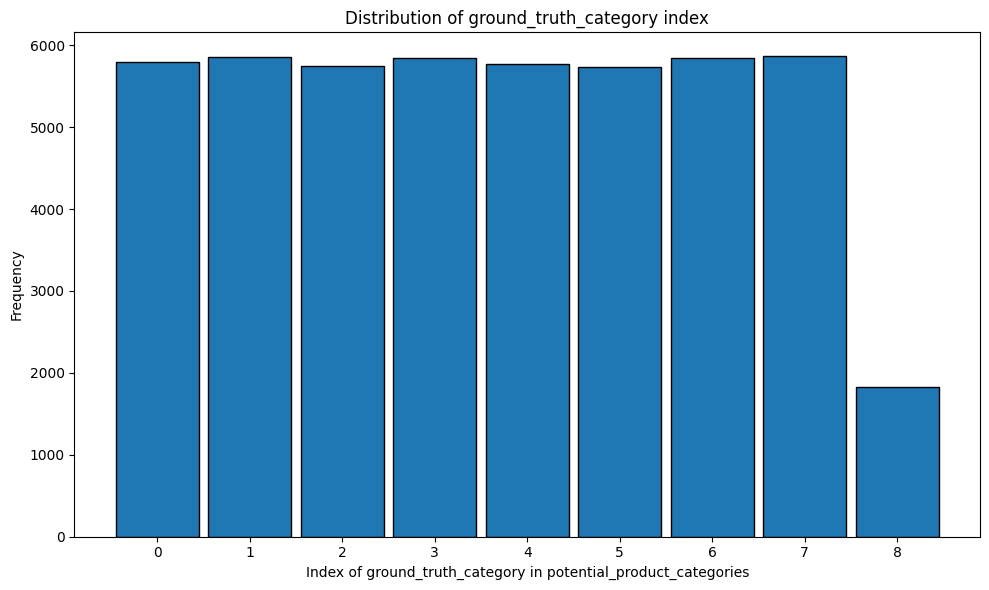

In [15]:
def plot_indices_ground_truth_category_in_potential_product_categories(dataset):
    # Plot histogram of positions/indices of ground_truth_category in potential_product_categories

    # Collect the indices
    position_indices = []
    for product in dataset:
        gt = product.get("ground_truth_category")
        pot = product.get("potential_product_categories", [])
        idx = pot.index(gt)
        position_indices.append(idx)

    # Plot the histogram
    plt.figure(figsize=(10,6))
    plt.hist(position_indices, bins=np.arange(-0.5, max(position_indices)+1.5, 1), edgecolor='black', rwidth=0.9)
    plt.xlabel("Index of ground_truth_category in potential_product_categories")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of ground_truth_category index")
    plt.xticks(range(min(position_indices), max(position_indices)+1))
    plt.tight_layout()
    plt.show()

plot_indices_ground_truth_category_in_potential_product_categories(dataset)

We wanna take a look into the distribution of the various fields.

In [16]:

def count_and_plot_top_n(dataset, value_fn, field_label, n=10):
    """
    Counts occurrences using a custom value extraction function.

    Args:
        dataset: The HuggingFace dataset as returned by load_dataset.
        split: The split of the dataset to use.
        value_fn: A function (product_dict) -> value, to extract the field to be counted.
        field_label: String label to describe the field when printing (default: function name or 'field').
        n: Number of top frequent items to print.
    """
    values = [value_fn(product) for product in dataset]
    # Remove Nones (missing values)
    values = [v for v in values if v is not None]
    counts = Counter(values)
    top_n = counts.most_common(n)
    import matplotlib.pyplot as plt

    # Use only the top n keys and their counts for the histogram
    keys = [key for key, _ in top_n]
    values = [count for _, count in top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), values, tick_label=[str(k) for k in keys])
    plt.title(f"Top {n} {field_label}")
    plt.xlabel(f"{field_label.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    assert counts.total() == len(dataset), f"Counts total {counts.total()} does not match dataset length {len(dataset)}"

The distribution of secondhand vs. new products are:

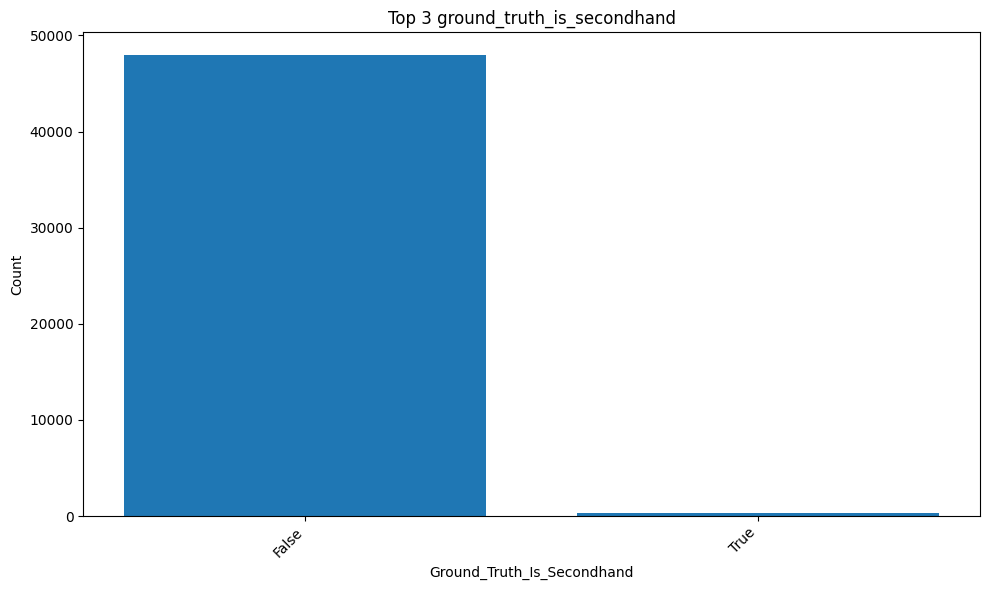

In [17]:
count_and_plot_top_n(dataset, lambda p: p.get('ground_truth_is_secondhand'), field_label='ground_truth_is_secondhand', n=3)

The distribution of the image sizes are:

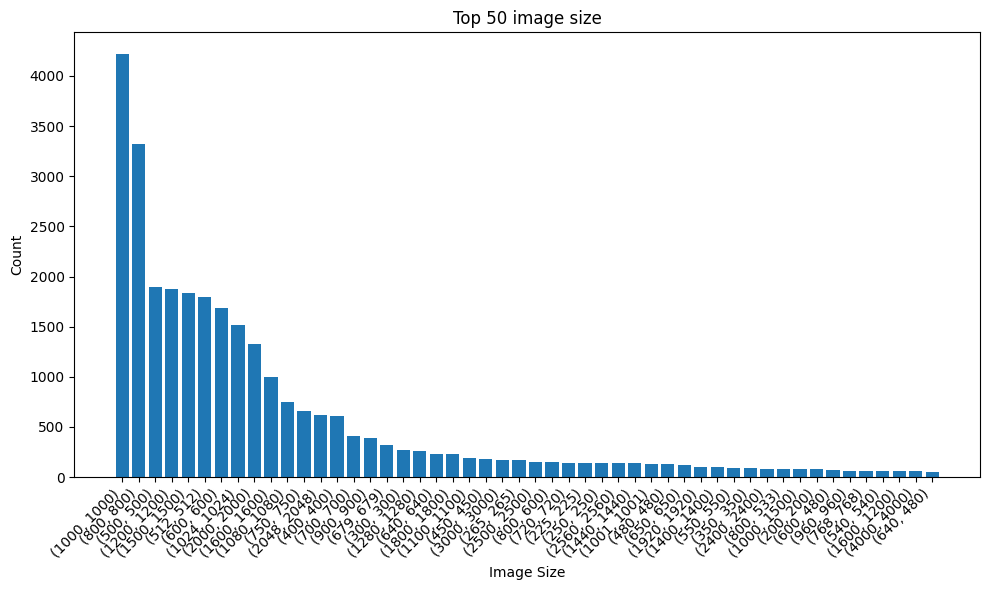

In [18]:
count_and_plot_top_n(dataset, lambda p: (p.get('product_image').width, p.get('product_image').height), field_label='image size', n=50)

The distribution of the number of visual tokens is:

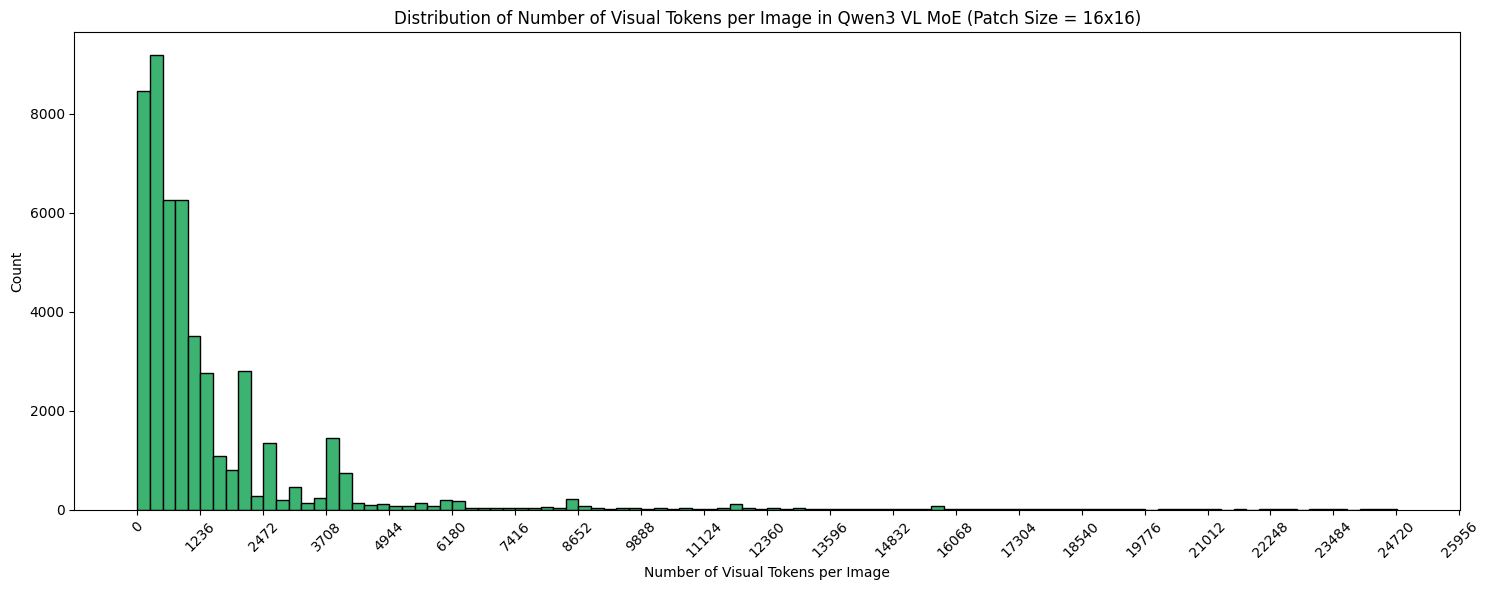

In [19]:
def plot_visual_tokens_distribution(dataset):
    patch_size = 16
    spatial_merge_size = 2

    num_visual_tokens = [
        (p['product_image'].width // patch_size // spatial_merge_size) * (p['product_image'].height // patch_size // spatial_merge_size)
        for p in dataset
        if p.get('product_image') is not None
    ]

    plt.figure(figsize=(15,6))
    hist_vals, bin_edges, _ = plt.hist(num_visual_tokens, bins=100, color='mediumseagreen', edgecolor='black')
    plt.title(f"Distribution of Number of Visual Tokens per Image in Qwen3 VL MoE (Patch Size = {patch_size}x{patch_size})")
    plt.xlabel("Number of Visual Tokens per Image")

    tick_step = int((max(num_visual_tokens) - min(num_visual_tokens)) / 20)  # 20 ticks
    if tick_step > 0:
        ticks = np.arange(min(num_visual_tokens), max(num_visual_tokens) + tick_step, tick_step)
        plt.xticks(ticks, rotation=45)

    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_visual_tokens_distribution(dataset)

The image file formats are:

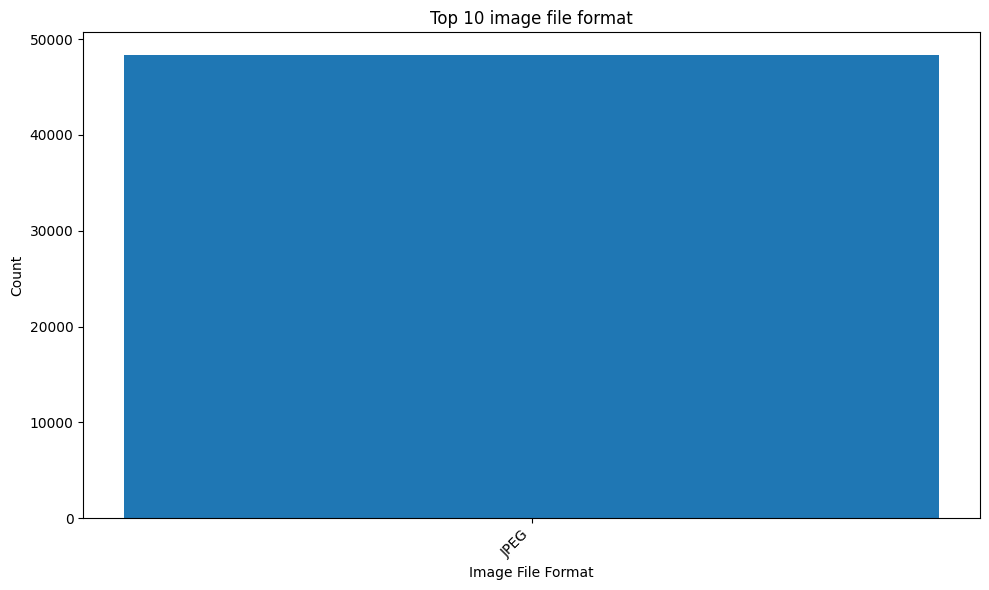

In [20]:
count_and_plot_top_n(dataset, lambda p: p['product_image'].format, field_label='image file format', n=10)